In [1]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

# Libraries

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

from jupyterthemes import jtplot
jtplot.style()

import xgboost as xg
from xgboost import XGBModel
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.preprocessing import LabelEncoder

%matplotlib inline
%load_ext autotime
%load_ext line_profiler
%matplotlib inline 

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def plot_best_features(model, data, num_features, figsize=(5,50)):
    """ 
    Plot best features. 
    
    Args:
        model (XGBRegressor) : The best XGBRegressor estimator from GridSearchCV or other 
                               model of type XGBRegressor.
        data     (DataFrame) : Data containing all features and column names.
        
    Returns:
        dict : The newly created dictionary, which maps 'data' features to their associated score.
        
    """
    
    new_scores = {}
    # Get the XGB Model's score and assign values and keys to the new dictionary
    scores = model.booster().get_score(importance_type='weight')
    for i in scores.keys():
        new_scores[data.columns[int(i[1:])]] = scores[i]
    # Build a dataframe with the top 'num_features'
    df_features = pd.DataFrame.from_records([new_scores], index=['Features']).T.sort_values('Features').tail(num_features)
    # Plot feature significance based on the models' score
    df_features.plot.barh(figsize=figsize)
    
    return new_scores

time: 5.69 ms


# Data Load

In [4]:
# Load data
transactions = pd.read_csv('../Data/properties_2016.csv', low_memory=False)
# Load train data
train_data = pd.read_csv('../Data/train_2016_v2.csv')
# Elements to be forecasted - this is the framework
submission_sample = pd.read_csv('../Data/sample_submission.csv')
# Load label description and feature documentation
label_documentation = pd.read_csv('../Data/zillow_data_dictionary.csv', encoding='ISO8859_1')

duplicate_records = train_data[train_data['parcelid'].duplicated()]['parcelid'].unique()

time: 31.2 s


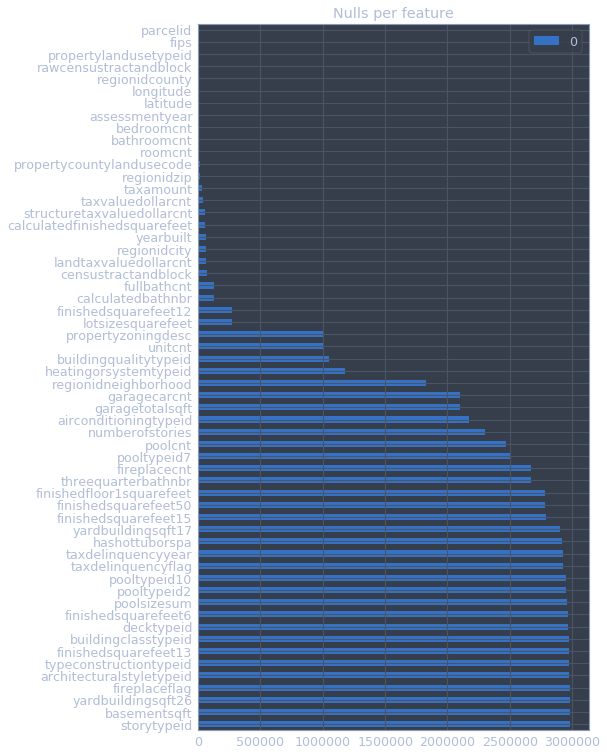

time: 4.22 s


In [5]:
# Show how many nulls there are for each feature
nulls = transactions.isnull().sum().sort_values(ascending=False).to_frame()
null_features = list(nulls[nulls[0] > 1200000].index) # Features which should be dropped due to having many nulls.
nulls.plot.barh(figsize=(7,13), title='Nulls per feature')

# Visualisation

/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


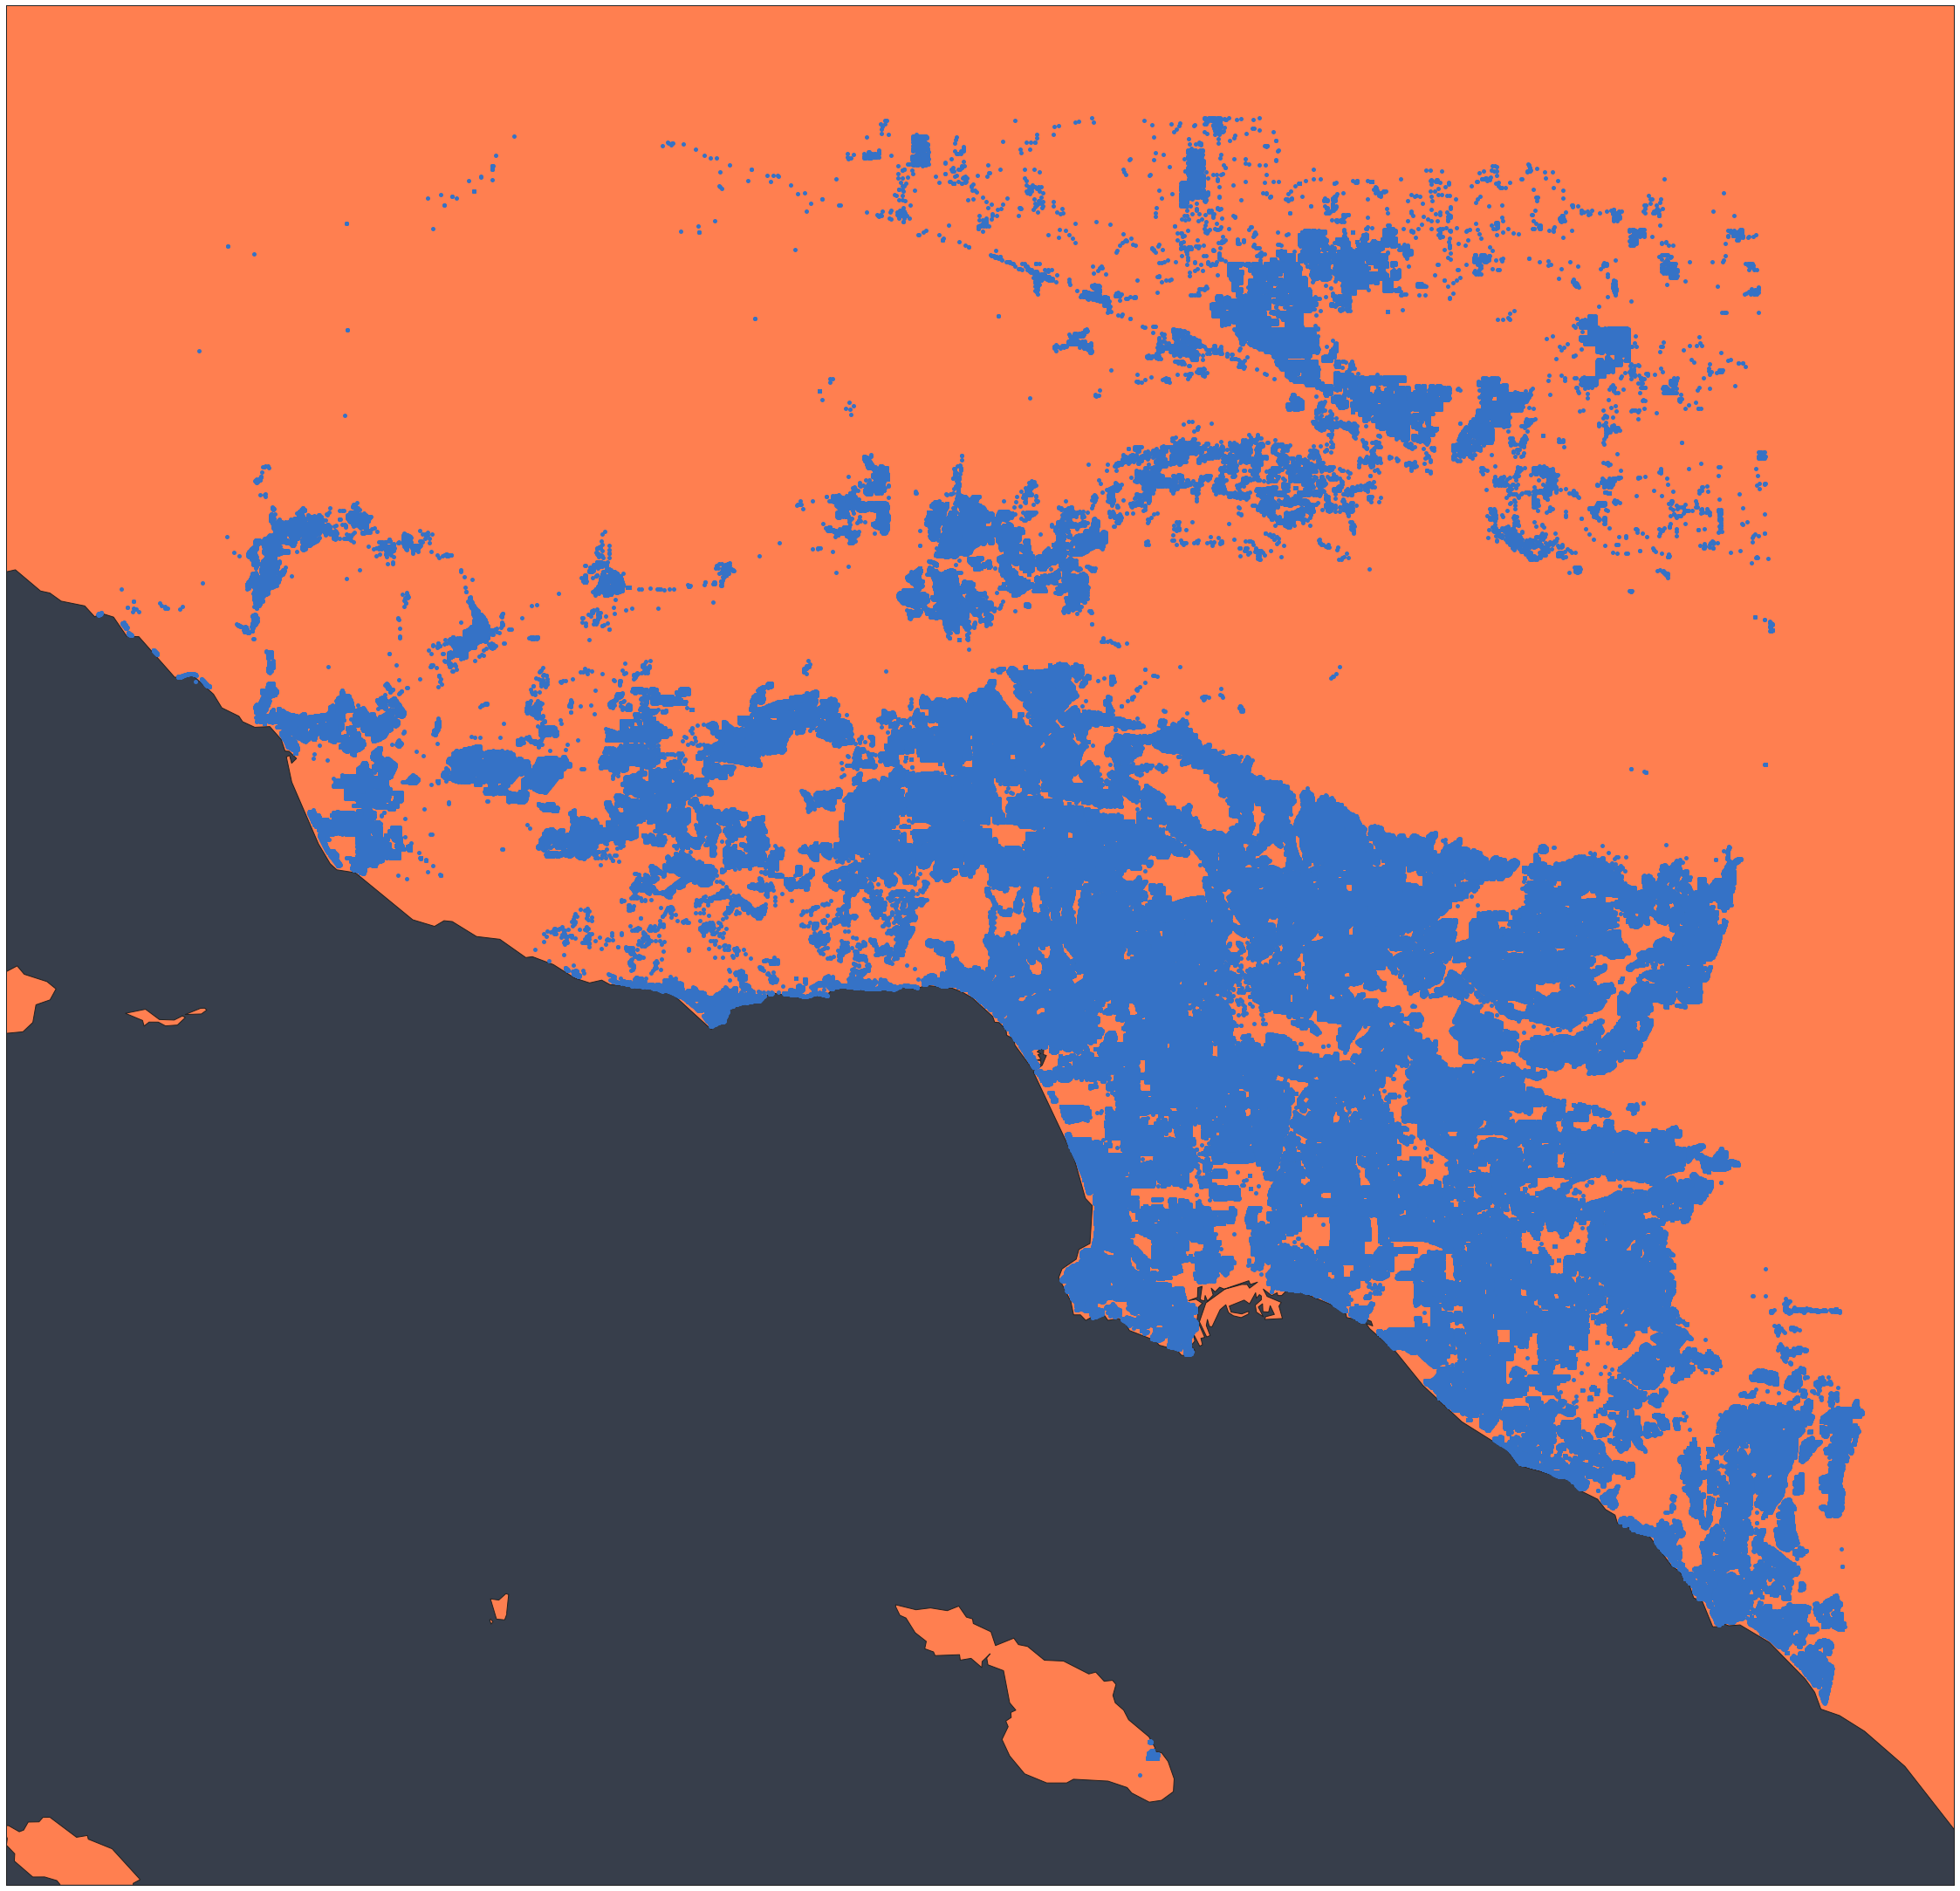

time: 26.7 s


In [6]:
transactions['latitude'] = transactions['latitude']/1000000
transactions['longitude'] = transactions['longitude']/1000000

# Get latitude and longitude extremes
min_lat = transactions['latitude'].min()
max_lat = transactions['latitude'].max()
min_lon = transactions['longitude'].min()
max_lon = transactions['longitude'].max()

# Build map
area = 0.1
fig = plt.figure(figsize=(40,40))
map = Basemap(projection='merc', lat_0 = np.mean([min_lat, max_lat]), lon_0 = np.mean([min_lon, max_lon]),
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=min_lon - area, llcrnrlat=min_lat - area,
    urcrnrlon=max_lon + area, urcrnrlat=max_lat + area)
 
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = 'coral')
map.drawmapboundary()
 
lon = transactions['longitude'].values
lat = transactions['latitude'].values
x,y = map(lon, lat)
map.plot(x, y, 'bo', markersize=5)

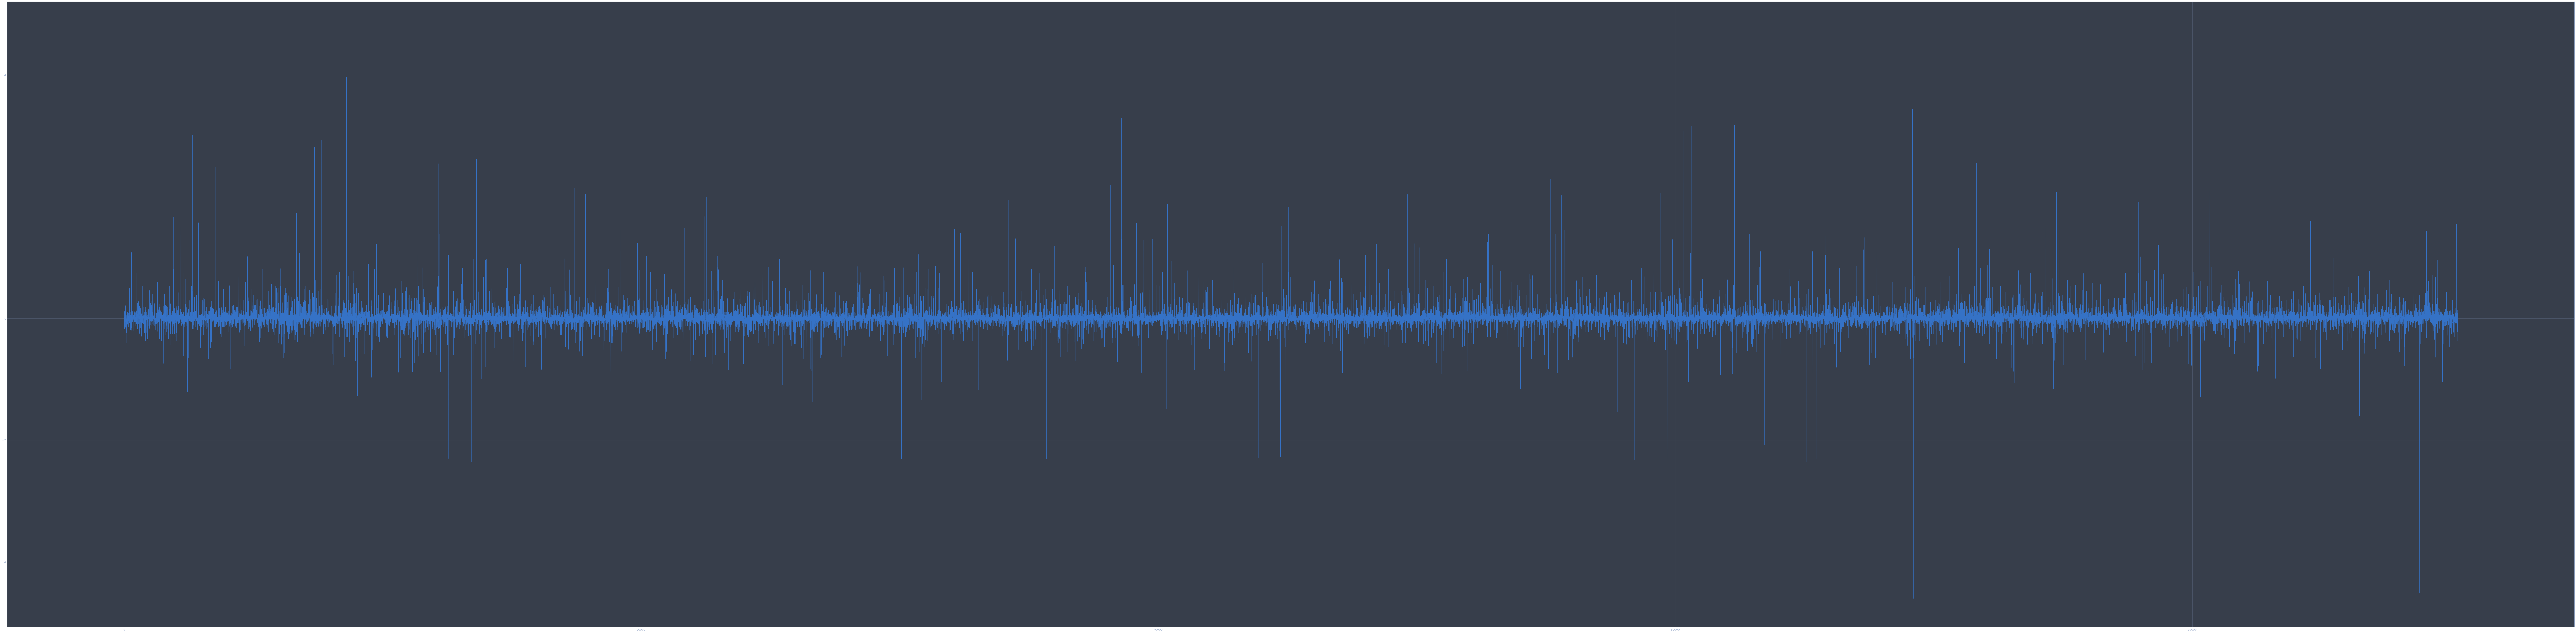

time: 11.1 s


In [7]:
fig = plt.figure(figsize=(200,50))
plt.plot(train_data['logerror'], linewidth=0.5)

In [8]:
label_documentation

Feature  \
0          'airconditioningtypeid'   
1       'architecturalstyletypeid'   
2                   'basementsqft'   
3                    'bathroomcnt'   
4                     'bedroomcnt'   
5          'buildingqualitytypeid'   
6            'buildingclasstypeid'   
7              'calculatedbathnbr'   
8                     'decktypeid'   
9            'threequarterbathnbr'   
10      'finishedfloor1squarefeet'   
11  'calculatedfinishedsquarefeet'   
12           'finishedsquarefeet6'   
13          'finishedsquarefeet12'   
14          'finishedsquarefeet13'   
15          'finishedsquarefeet15'   
16          'finishedsquarefeet50'   
17                          'fips'   
18                  'fireplacecnt'   
19                 'fireplaceflag'   
20                   'fullbathcnt'   
21                  'garagecarcnt'   
22               'garagetotalsqft'   
23                'hashottuborspa'   
24         'heatingorsystemtypeid'   
25                      'latitude'   
26                     'longitude'   
27             'lotsizesquarefeet'   
28               'numberofstories'   
29                      'parcelid'   
30                       'poolcnt'   
31                   'poolsizesum'   
32                  'pooltypeid10'   
33                   'pooltypeid2'   
34                   'pooltypeid7'   
35     'propertycountylandusecode'   
36         'propertylandusetypeid'   
37            'propertyzoningdesc'   
38        'rawcensustractandblock'   
39           'censustractandblock'   
40                'regionidcounty'   
41                  'regionidcity'   
42                   'regionidzip'   
43          'regionidneighborhood'   
44                       'roomcnt'   
45                   'storytypeid'   
46        'typeconstructiontypeid'   
47                       'unitcnt'   
48            'yardbuildingsqft17'   
49            'yardbuildingsqft26'   
50                     'yearbuilt'   
51             'taxvaluedollarcnt'   
52    'structuretaxvaluedollarcnt'   
53         'landtaxvaluedollarcnt'   
54                     'taxamount'   
55                'assessmentyear'   
56            'taxdelinquencyflag'   
57            'taxdelinquencyyear'   

                                          Description  
0    Type of cooling system present in the home (i...  
1    Architectural style of the home (i.e. ranch, ...  
2    Finished living area below or partially below...  
3    Number of bathrooms in home including fractio...  
4                         Number of bedrooms in home   
5    Overall assessment of condition of the buildi...  
6   The building framing type (steel frame, wood f...  
7    Number of bathrooms in home including fractio...  
8             Type of deck (if any) present on parcel  
9    Number of 3/4 bathrooms in house (shower + si...  
10   Size of the finished living area on the first...  
11   Calculated total finished living area of the ...  
12                  Base unfinished and finished area  
13                               Finished living area  
14                             Perimeter  living area  
15                                         Total area  
16   Size of the finished living area on the first...  
17   Federal Information Processing Standard code ...  
18            Number of fireplaces in a home (if any)  
19               Is a fireplace present in this home   
20   Number of full bathrooms (sink, shower + bath...  
21   Total number of garages on the lot including ...  
22   Total number of square feet of all garages on...  
23                Does the home have a hot tub or spa  
24                        Type of home heating system  
25   Latitude of the middle of the parcel multipli...  
26   Longitude of the middle of the parcel multipl...  
27                     Area of the lot in square feet  
28           Number of stories or levels the home has  
29              Unique identifier for parcels (lots)   
30                Number of pools on the lot (if

time: 11.6 ms


# Processing

In [13]:
# RAW DATA FEATURES
raw_transactions = pd.read_csv('../Data/properties_2016.csv', low_memory=False)

# Replace null values, identify duplicates.
transactions_shuffled = pd.merge(train_data, raw_transactions, how='left', on=['parcelid']).sample(frac=1)
transactions_shuffled['taxdelinquencyflag'] = transactions_shuffled['taxdelinquencyflag'].replace('Y',0)

transactions_shuffled['code_fips']  = transactions_shuffled['rawcensustractandblock'].apply(lambda x: str(x)[:4]).replace('',0)
transactions_shuffled['code_tract'] = transactions_shuffled['rawcensustractandblock'].apply(lambda x: str(x)[4:11]).replace('',0)
transactions_shuffled['code_block'] = transactions_shuffled['rawcensustractandblock'].apply(lambda x: str(x)[11:]).replace('',0)

transactions_shuffled['transactiondate'] = pd.to_datetime(transactions_shuffled['transactiondate'])
transactions_shuffled['day_of_month'] = transactions_shuffled['transactiondate'].dt.day
transactions_shuffled['month_of_year'] = transactions_shuffled['transactiondate'].dt.month
transactions_shuffled['quarter'] = transactions_shuffled['transactiondate'].dt.quarter

y_all = transactions_shuffled['logerror']
x_all = transactions_shuffled.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
x_all.fillna(-999, inplace=True)

# Splits up train and test based on the given ration
ratio = 0.1
best_columns = x_all.columns
x_train, x_test, y_train, y_test = train_test_split(x_all.values, y_all, test_size=ratio, random_state=69)

time: 36.1 s


# Linear Regression

R2 LR Test: 0.0069126576055
R2 LR Train: 0.00715800778748
MAE LR Test: 0.0684235112172
MAE LR Train: 0.0683704761807


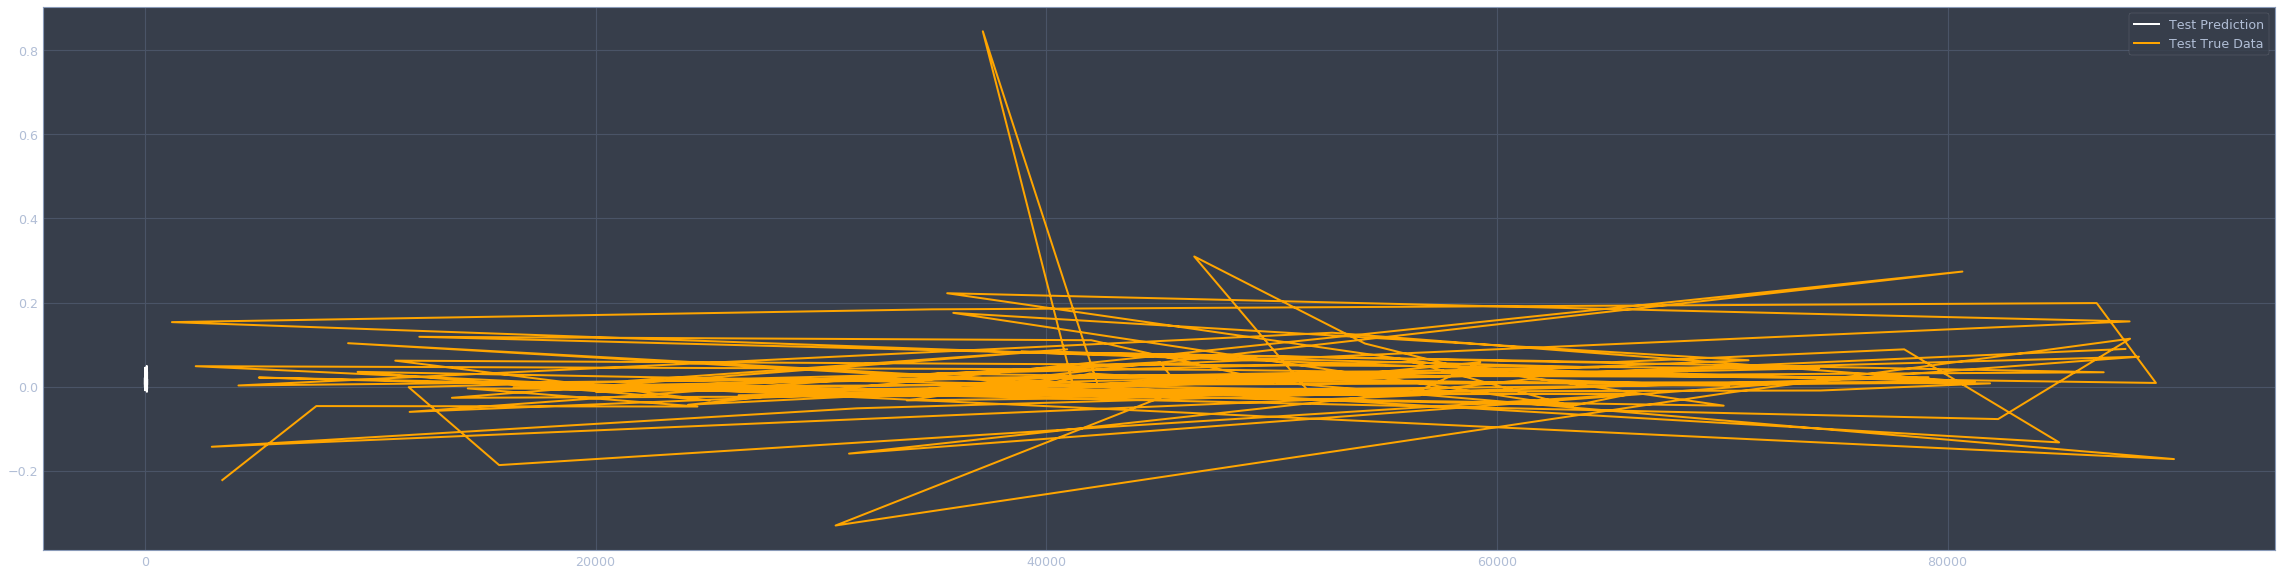

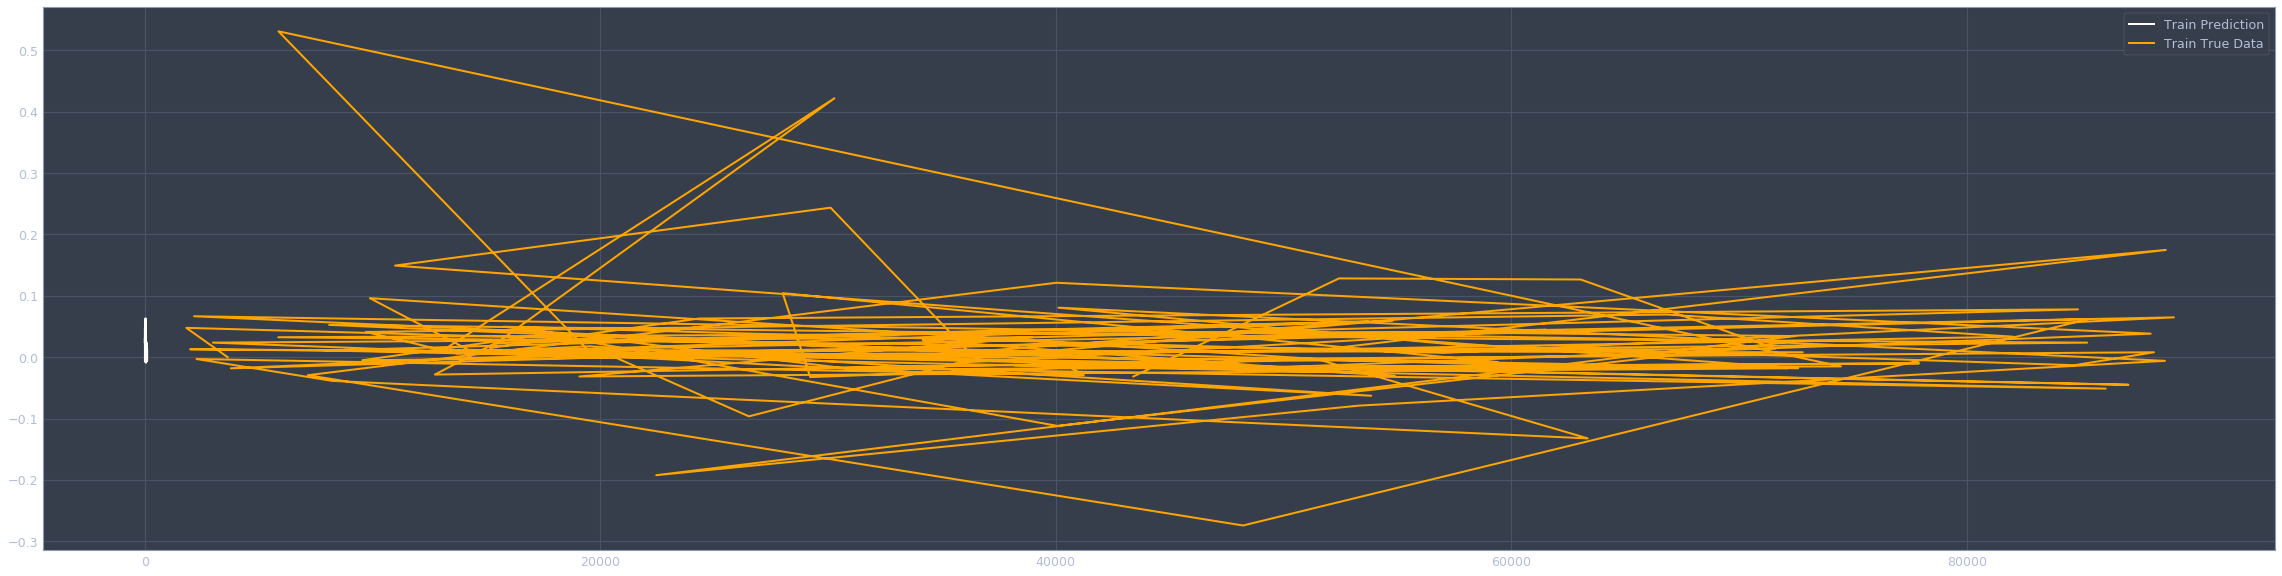

time: 3.07 s


In [14]:
model_lr = LinearRegression()
# Fir the model to train data
model_lr.fit(x_train, y_train)

#selector = RFE(LinearRegression(), 200, step=100)
#selector = selector.fit(x_train, y_train)

# Make a prediction for the test set
y_pred_lr_test = model_lr.predict(x_test)
y_pred_lr_train = model_lr.predict(x_train)
# Score the predictor on the test set
#model_lr.score(x_test, y_test)
# Feature importance
feature_importance_lr = pd.DataFrame(model_lr.coef_, columns=['Weight'], index=best_columns).sort_values('Weight', ascending=False)
# Same R2 computation based but based on metrics library
print('R2 LR Test:', r2_score(y_test, y_pred_lr_test))
print('R2 LR Train:', r2_score(y_train, y_pred_lr_train))

predicted_mae_lr_test = mean_absolute_error(y_test, y_pred_lr_test)
print('MAE LR Test:', predicted_mae_lr_test)
predicted_mae_lr_train = mean_absolute_error(y_train, y_pred_lr_train)
print('MAE LR Train:', predicted_mae_lr_train)


sample = 100 # Number of records to look at - makes the visualisation more meaningful.
# Plot test true vs predicted values
plot_data(y_test, y_pred_lr_test, sample, 'Test', linewidth=2)
# Plot train true vs predicted values
plot_data(y_train, y_pred_lr_train, sample, 'Train', linewidth=2)

# XGB

In [15]:
params={
    'max_depth':        3, # shuld be 0.5 to 1% of the examples
    'subsample':        1, #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    'min_child_weight': 12, # Deals with imbalanced data.
    'gamma':            0.2,
    #'colsample_bytree': [0.5], #[0.5,0.6,0.7,0.8],
    'objective':        'reg:linear',
    'n_estimators':     1000, #[1000,2000,3000]
    'reg_alpha':        0, #[0.01, 0.02, 0.03, 0.04]
    'learning_rate':    0.09,
    'scale_pos_weight': 1
}

time: 2.13 ms


In [16]:
d_train = xg.DMatrix(x_train, label=y_train)
d_valid = xg.DMatrix(x_test,  label=y_test)

print('Training ...')

params['eta'] = 0.02
params['eval_metric'] = 'mae'
params['silent'] = 1

# Top : train-mae:0.067973	valid-mae:0.064692
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
xgb_gs = xg.train(params, d_train, 10000, watchlist, early_stopping_rounds=50, verbose_eval=10)

Training ...
[0]	train-mae:0.453737	valid-mae:0.453797
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 50 rounds.
[10]	train-mae:0.193631	valid-mae:0.193817
[20]	train-mae:0.102769	valid-mae:0.102952
[30]	train-mae:0.07607	valid-mae:0.076365
[40]	train-mae:0.069804	valid-mae:0.070085
[50]	train-mae:0.068364	valid-mae:0.06872
[60]	train-mae:0.067961	valid-mae:0.068417
[70]	train-mae:0.067815	valid-mae:0.068334
[80]	train-mae:0.067749	valid-mae:0.068339
[90]	train-mae:0.067713	valid-mae:0.068362
[100]	train-mae:0.067687	valid-mae:0.068371
[110]	train-mae:0.067672	valid-mae:0.068444
[120]	train-mae:0.067666	valid-mae:0.068505
Stopping. Best iteration:
[75]	train-mae:0.067769	valid-mae:0.068333

time: 19.1 s


In [ ]:
cv = 5
jobs = 5

# Build XGB model based on the given parameters.
# Default features:
# max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', 
# booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
# subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None


xgbr = xg.XGBRegressor()
xgb_gs = GridSearchCV(xgbr, params, n_jobs=jobs, 
                      cv=TimeSeriesSplit(n_splits=cv).get_n_splits([x_train, y_train]), 
                      #scoring='neg_mean_absolute_error',
                      verbose=10, refit=True)

xgb_gs.fit(x_train, y_train)

In [ ]:
print('Best estimator:',xgb_gs.best_estimator_)

# Predict estimated logerror
y_pred_xgb_test = xgb_gs.predict(x_test)
y_pred_xgb_train = xgb_gs.predict(x_train)
# Evaluate the performance of XGB
print('XGB R2 Test:', xgb_gs.score(x_test, y_test))
print('XGB R2 Train:', xgb_gs.score(x_train, y_train))

# Show results for LR on train and test data
print('MAE LR  Test:', predicted_mae_lr_test)
print('MAE LR  Train:', predicted_mae_lr_train)


# Show results for XGB on train and test data
predicted_mae_xgb_test = mean_absolute_error(y_test, y_pred_xgb_test)
print('MAE XGB Test:',predicted_mae_xgb_test)
predicted_mae_xgb_train = mean_absolute_error(y_train, y_pred_xgb_train)
print('MAE XGB Train:', predicted_mae_xgb_train)


#selector = RFE(xgb_gs.best_estimator_, 100, step=50)
#selector = selector.fit(x_train, y_train)

# plot feature importance
dict_features = plot_best_features(xgb_gs.best_estimator_, data=x_all, num_features=50, figsize=(5,13))
#xgb.to_graphviz(xgb_gs.best_estimator_, num_trees=50)

######## ONE-HOT vs NONE ######
# ONE-HOT:
# XGB R2 Test: -0.0135715900237 Train: 0.13302709163
# MAE LR  Train: 0.0687819933569 Test: 0.0675078152125
# MAE XGB Train: 0.0669039183129 Test: 0.0687189110259

# NONE:
# XGB R2 Test: 0.011877997183 Train: 0.141170034298
# MAE LR  Train: 0.0680096936624 Test: 0.0713713207428
# MAE XGB Train: 0.0662614095391 Test: 0.0722176694789
######## Label Encoder #######


In [60]:
best_columns = x_all.columns

time: 711 µs


In [114]:
for d in [10,11,12]:
    x_predict = raw_transactions.copy()
    x_predict['code_fips']  = x_predict['rawcensustractandblock'].apply(lambda x: str(x)[:4]).replace('',0)
    x_predict['code_tract'] = x_predict['rawcensustractandblock'].apply(lambda x: str(x)[4:11]).replace('',0)
    x_predict['code_block'] = x_predict['rawcensustractandblock'].apply(lambda x: str(x)[11:]).replace('',0)
    x_predict['taxdelinquencyflag'] = x_predict['taxdelinquencyflag'].replace('Y',0)
    
    x_predict['month_of_year'] = d
    x_predict['quarter'] = 4
    x_predict['day_of_month'] = 1
    #x_predict['month_of_year'] = d
    #x_predict['quarter'] = 4
    predictions = xgb_gs.predict(xg.DMatrix(x_predict[best_columns].values))
    x_predict['2016%s'%(d)] = predictions
    submission_sample['2016%s'%(d)] = submission_sample['ParcelId'].to_frame().merge(x_predict[['parcelid','2016%s'%(d)]], how='left', left_on='ParcelId', right_on='parcelid')['2016%s'%(d)]

time: 3min 2s


In [115]:
submission_sample.to_csv('submission3.csv',index=False)
submission_sample.head()

ParcelId    201610    201611    201612  201710  201711  201712
0  10754147  0.106688  0.106688  0.106688       0       0       0
1  10759547 -0.161561 -0.161561 -0.161561       0       0       0
2  10843547  0.161720  0.161720  0.161720       0       0       0
3  10859147  0.185503  0.185503  0.185503       0       0       0
4  10879947  0.001469  0.001469  0.001469       0       0       0

time: 24.3 s
